# The myelin-weighted connectome: complementing brain networks with a myelin-sensitive measure 


## Connectivity preprocessing - Constructing group connectivity matrices

In [1]:
from IPython.display import display, HTML, IFrame
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import scipy.io as sio
import numpy as np
import bct
import plotly.express as px
import plotly
import pandas as pd
import scipy.stats as sts
import json

from netneurotools import plotting
from netneurotools import cluster
from netneurotools import modularity as mod
import matplotlib.pyplot as plt
import os

init_notebook_mode(connected=True)
config = {'showLink': False, 'displayModeBar': False}



#Mapping of Lausanne 2008 (scale 125) parcellation to the Yeo's 7 networks and von Economo classes
yeo_net = sio.loadmat('atlas_names.mat')['yeo_net'][0]
ve_net = sio.loadmat('atlas_names.mat')['ve_net'][0]

#Removing the non-cortical regions from the lausanne parcellation 
ve = ve_net[ve_net>0];
yeo = yeo_net[yeo_net>0];

#Lausanne 2008 (scale 125) node names
nodes_names = sio.loadmat('atlas_names.mat')['node_names']

yeo_net_names=['vis','sm','da','va','lim','fp','dmn']
ve_net_names=['pm', 'asc1', 'asc2', 'pss','ps', 'lim', 'ins']


def count_occurances(x):
    out = {}
    for i in range(0, len(yeo_net_names)):
        out[yeo_net_names[i]] = x.count(yeo_net_names[i])
    return out

def node_weighted_average(r1,nos):
    c = np.divide(bct.algorithms.strengths_und(np.multiply(r1,nos)),bct.algorithms.strengths_und(nos))
    return c

Define the NOS threshold for eliminating spurious connections and load the group connectivity matrices

In [2]:
thresh = 5

In [3]:
if(thresh==2):
    consensusNetworks = sio.loadmat('group_connectivity_thr_2.mat')
elif(thresh==5):
    consensusNetworks = sio.loadmat('group_connectivity_thr_5.mat')

Compute the group consensus networks for the NOS, R1, and FA-weighted connectomes

## Connection level relationship between the R1- and NOS-, and R1- and FA-weigthed connectomes

In [4]:
# Get the upper triangular matrices of the R1, NOS, and FA group connectomes

xx = consensusNetworks["r1"][np.triu_indices(219, k = 1)];
yy = consensusNetworks["nos"][np.triu_indices(219, k = 1)];
zz = consensusNetworks["fa"][np.triu_indices(219, k = 1)];

df = pd.DataFrame(dict(R1=xx[xx>0], NOS=yy[yy>0], FA=zz[zz>0]))

fig1 = px.scatter(df, x="R1", y="NOS" ,labels={'x':'R1', 'y':'NOS'}, trendline="ols")
fig1.update_xaxes(tickfont=dict(size=16), title_font=dict(size=18))
fig1.update_yaxes(tickfont=dict(size=16), title_font=dict(size=18))
results = px.get_trendline_results(fig1)
fig1.update_layout(
    annotations=[
        dict(
            x=0.05,
            y=0.9,
            showarrow=False,
            text="<b>R<sup>2</sup> = " + '{:.3f}'.format(results.px_fit_results.iloc[0].rsquared_adj) + " </b>",
            xref="paper",
            yref="paper",
            font=dict(
                size=16,
                color="red"
            ),
        )])
#HTML(filename="images/R1_NOS-scatter-5.html")
#fig1.write_html("images/R1_NOS-scatter-5.html")
fig1.show()


fig2 = px.scatter(df, x="R1", y="FA",labels={'x':'R1', 'y':'FA'}, trendline="ols")
fig2.update_xaxes(tickfont=dict(size=16), title_font=dict(size=18))
fig2.update_yaxes(tickfont=dict(size=16), title_font=dict(size=18))
results = px.get_trendline_results(fig2)
fig2.update_layout(
    annotations=[
        dict(
            x=0.05,
            y=0.93,
            showarrow=False,
            text="<b>R<sup>2</sup> =" + '{:.3f}'.format(results.px_fit_results.iloc[0].rsquared_adj) + " </b>",
            xref="paper",
            yref="paper",
            font=dict(
                size=16,
                color="red"
            ),
        )])
#fig2.write_html("images/R1_FA-scatter-5.html")
#HTML(filename="images/R1_FA-scatter-5.html")
fig2.show()

## Node strength and weighted average


The node strength is calculates as:
\begin{equation}\label{eq:1}
S_i = \sum_{j=1}^{j=N}{NOS_{i,j}}
\end{equation}

$$ $$


The node weighted average is calculates as:
\begin{equation}\label{eq:2}
g(i) = \frac{\sum_{j=1}^{j=N}{NOS_{i,j} \cdot R1_{i,j}}}{\sum_{j=1}^{j=N}{NOS_{i,j}}}
\end{equation}

$$ $$


In [5]:
#NOS strength distribution
colors = ['blue',] * 219
colors[1] = 'crimson'
fig  = go.Figure();
ss = -np.sort(-np.asarray(bct.algorithms.strengths_und(consensusNetworks["nos"])))
X = bct.algorithms.strengths_und(consensusNetworks["nos"])
Z = [x for _,x in sorted(zip(X,nodes_names), reverse=True)]


nos_strength_mean = np.mean(ss)
nos_strength_std = np.std(ss)

idx_nos = next(x[0] for x in enumerate(ss) if x[1] < nos_strength_mean + nos_strength_std)
idx_names_nos = Z[0:idx_nos]

idx2_nos = next(x[0] for x in enumerate(ss) if x[1] < nos_strength_mean + 2*nos_strength_std)
idx3_nos = next(x[0] for x in enumerate(ss) if x[1] < nos_strength_mean + 3*nos_strength_std)

idx_names2_nos = Z[0:idx2_nos]
idx_names3_nos = Z[0:idx3_nos]

colors[0:idx_nos] = ['#ff7f0e',] * (idx_nos+1)
colors[0:idx2_nos] = ['crimson',] * (idx2_nos+1)

fig.add_trace(go.Bar(x = Z, y = ss, marker_color=colors))
fig.update_yaxes(title_text="NOS strength", tickfont=dict(size=15), title_font=dict(size=18), automargin=True, title_standoff = 25)
fig.update_xaxes(showticklabels=False, title="Nodes", tickfont=dict(size=15), title_font=dict(size=18))
fig.update_layout(title='Strength NOS', height=300, margin=dict(l=100))
iplot(fig)


 

#R1-weighted average distribution
colors1 = ['blue',] * 219
colors1[1] = 'crimson'

fig1  = go.Figure();

ss = -np.sort(-np.asarray(node_weighted_average(consensusNetworks["r1"],consensusNetworks["nos"])))
X = node_weighted_average(consensusNetworks["r1"],consensusNetworks["nos"]);
Z = [x for _,x in sorted(zip(X,nodes_names), reverse=True)]

idx_r1 = [ Z.index(idx_names_nos[x]) for x in range(0,len(idx_names_nos))]
idx2_r1 = [ Z.index(idx_names2_nos[x]) for x in range(0,len(idx_names2_nos))]

for i in idx_r1:
    colors1[i] = '#ff7f0e'

for i in idx2_r1:
    colors1[i] = 'crimson'
    
fig1.add_trace(go.Bar(x = Z, y = ss,marker_color=colors1))
fig1.update_yaxes(title_text="$$R1 [s^{-1}]$$", tickfont=dict(size=15), title_font=dict(size=18))
fig1.update_xaxes(showticklabels=False, title="Nodes", tickfont=dict(size=15), title_font=dict(size=18))
fig1.update_layout(title='R1-weighted average', height=300)
iplot(fig1)

#FA-weighted average distribution
colors1 = ['blue',] * 219
colors1[1] = 'crimson'

fig2  = go.Figure();
ss = -np.sort(-np.asarray(node_weighted_average(consensusNetworks["fa"],consensusNetworks["nos"])))
X = node_weighted_average(consensusNetworks["fa"],consensusNetworks["nos"]);
Z = [x for _,x in sorted(zip(X,nodes_names), reverse=True)]

idx_fa = [ Z.index(idx_names_nos[x]) for x in range(0,len(idx_names_nos))]
idx2_fa = [ Z.index(idx_names2_nos[x]) for x in range(0,len(idx_names2_nos))]
for i in idx_fa:
    colors1[i] = '#ff7f0e'

for i in idx2_fa:
    colors1[i] = 'crimson'
    
fig2.add_trace(go.Bar(x = Z, y = ss,marker_color=colors1))
fig2.update_xaxes(showticklabels=False, title="Nodes", tickfont=dict(size=15), title_font=dict(size=18))
fig2.update_yaxes(title_text="$$FA$$", tickfont=dict(size=15), title_font=dict(size=18))
fig2.update_layout(title='FA-weighted average', height=300)

iplot(fig2)

## Rank-based analysis

### Computation of the ranks

In [6]:
comm_labels_yeo = ['vis','sm','da','va','lim','fp','dmn'];
labels1_yeo = comm_labels_yeo
labels2_yeo = comm_labels_yeo
labels3_yeo = comm_labels_yeo

R1_strength = node_weighted_average(consensusNetworks["r1"],consensusNetworks["nos"]);
R1_rank = sorted(range(len(R1_strength)), key=lambda k: R1_strength[k], reverse=True)


FA_strength = node_weighted_average(consensusNetworks["fa"],consensusNetworks["nos"]).tolist();
FA_rank = sorted(range(len(FA_strength)), key=lambda k: FA_strength[k], reverse=True)

NOS_strength = bct.algorithms.strengths_und(consensusNetworks["nos"]).tolist();
NOS_rank = sorted(range(len(NOS_strength)), key=lambda k: NOS_strength[k], reverse=True)

R1_rank1 = np.zeros(len(R1_rank))
FA_rank1 = np.zeros(len(FA_rank))
NOS_rank1 = np.zeros(len(NOS_rank))

for i in range(1,220):
    R1_rank1[R1_rank[i-1]]=i;
    NOS_rank1[NOS_rank[i-1]]=i;
    FA_rank1[FA_rank[i-1]]=i;


R1_NOS = sts.zscore(R1_rank1 - NOS_rank1);
R1_FA = sts.zscore(R1_rank1 - FA_rank1);
FA_NOS = sts.zscore(FA_rank1 - NOS_rank1);


# Yeo 7 Networks

R1_NOS_rank_yeo_tmp = np.zeros(7)
R1_FA_rank_yeo_tmp = np.zeros(7)
FA_NOS_rank_yeo_tmp = np.zeros(7)

for i in range(1,8):
    R1_NOS_rank_yeo_tmp[i-1] = np.median(R1_NOS[yeo==i])
    R1_FA_rank_yeo_tmp[i-1] = np.median(R1_FA[yeo==i])
    FA_NOS_rank_yeo_tmp[i-1] = np.median(FA_NOS[yeo==i])

R1_NOS_rank_yeo = -np.sort(-R1_NOS_rank_yeo_tmp)
R1_FA_rank_yeo = -np.sort(-R1_FA_rank_yeo_tmp)
FA_NOS_rank_yeo = -np.sort(-FA_NOS_rank_yeo_tmp)

labels1_yeo =[x for _,x in sorted(zip(R1_NOS_rank_yeo_tmp,comm_labels_yeo), reverse=True)]
labels2_yeo =[x for _,x in sorted(zip(R1_FA_rank_yeo_tmp,comm_labels_yeo), reverse=True)]
labels3_yeo =[x for _,x in sorted(zip(FA_NOS_rank_yeo_tmp,comm_labels_yeo), reverse=True)]



#von Economo 

comm_labels_economo = ['pm', 'asc1', 'asc2', 'pss','ps', 'lim', 'ins'];
labels1_economo = comm_labels_economo
labels2_economo = comm_labels_economo
labels3_economo = comm_labels_economo

R1_NOS_rank_economo_tmp = np.zeros(7)
R1_FA_rank_economo_tmp = np.zeros(7)
FA_NOS_rank_economo_tmp = np.zeros(7)


for i in range(1,8):
    R1_NOS_rank_economo_tmp[i-1] = np.median(R1_NOS[ve==i]) 
    R1_FA_rank_economo_tmp[i-1] = np.median(R1_FA[ve==i])
    FA_NOS_rank_economo_tmp[i-1] = np.median(FA_NOS[ve==i])

R1_NOS_rank_economo = -np.sort(-R1_NOS_rank_economo_tmp)
R1_FA_rank_economo = -np.sort(-R1_FA_rank_economo_tmp)
FA_NOS_rank_economo = -np.sort(-FA_NOS_rank_economo_tmp)

labels1_economo =[x for _,x in sorted(zip(R1_NOS_rank_economo_tmp,comm_labels_economo), reverse=True)]
labels2_economo =[x for _,x in sorted(zip(R1_FA_rank_economo_tmp,comm_labels_economo), reverse=True)]
labels3_economo =[x for _,x in sorted(zip(FA_NOS_rank_economo_tmp,comm_labels_economo), reverse=True)]


# define the colors for the Yeo's and von Economo classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
yeo_colors = dict()
yeo_colors['sm'] = '#1f77b4'
yeo_colors['va'] = '#ff7f0e'
yeo_colors['vis'] = '#2ca02c'
yeo_colors['fp'] = '#d62728'
yeo_colors['dmn'] = '#9467bd'
yeo_colors['lim'] = '#8c564b'
yeo_colors['da'] = '#e377c2'

ve_colors = dict()
ve_colors['pm'] = '#1f77b4'
ve_colors['asc1'] = '#ff7f0e'
ve_colors['asc2'] = '#2ca02c'
ve_colors['pss'] = '#d62728'
ve_colors['ps'] = '#9467bd'
ve_colors['lim'] = '#8c564b'
ve_colors['ins'] = '#e377c2'


# Assign yeo's/vonEconomo's class name to each node

nodes_yeo_names = yeo
nodes_yeo_names = np.where(yeo==1, yeo_net_names[0], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==2, yeo_net_names[1], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==3, yeo_net_names[2], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==4, yeo_net_names[3], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==5, yeo_net_names[4], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==6, yeo_net_names[5], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==7, yeo_net_names[6], nodes_yeo_names)

nodes_ve_names = ve
nodes_ve_names = np.where(ve==1, ve_net_names[0], nodes_ve_names)
nodes_ve_names = np.where(ve==2, ve_net_names[1], nodes_ve_names)
nodes_ve_names = np.where(ve==3, ve_net_names[2], nodes_ve_names)
nodes_ve_names = np.where(ve==4, ve_net_names[3], nodes_ve_names)
nodes_ve_names = np.where(ve==5, ve_net_names[4], nodes_ve_names)
nodes_ve_names = np.where(ve==6, ve_net_names[5], nodes_ve_names)
nodes_ve_names = np.where(ve==7, ve_net_names[6], nodes_ve_names)


### Rank-based comparison for the Yeo's 7 functional networks

In [24]:
clr1 = [yeo_colors[str(x)] for x in labels1_yeo]
clr2 = [yeo_colors[str(x)] for x in labels2_yeo]
clr3 = [yeo_colors[str(x)] for x in labels3_yeo]


fig = go.Figure([go.Bar(x=labels1_yeo, y=R1_NOS_rank_yeo,marker_color=clr1)], layout = go.Layout(title ='R1_NOS', yaxis=dict(title='Rank(R1) - Rank(NOS)')))
fig.update_yaxes(tickfont=dict(size=15), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=15), title_font=dict(size=18))
iplot(fig)


colors1 = ["cyan", "green", "goldenrod", "magenta", "red", "blue", "purple"]
fig = go.Figure([go.Bar( x=labels2_yeo, y=R1_FA_rank_yeo, marker_color=clr2)], layout = go.Layout(title ='R1_FA', yaxis=dict(title='Rank(R1) - Rank(FA)')))
fig.update_yaxes(tickfont=dict(size=15), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=15), title_font=dict(size=18))
iplot(fig)



colors2 = ["goldenrod", "purple", "green", "cyan", "magenta", "blue", "red"]
fig = go.Figure([go.Bar(x=labels3_yeo, y=FA_NOS_rank_yeo, marker_color=clr3)], layout = go.Layout(title ='FA_NOS', yaxis=dict(title='Rank(FA) - Rank(NOS)')))
fig.update_yaxes(tickfont=dict(size=15), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=15), title_font=dict(size=18))
iplot(fig)


### Rank-based comparison for the von Economo cytoarchitectural classes 

In [25]:
clr4 = [ve_colors[str(x)] for x in labels1_economo]
clr5 = [ve_colors[str(x)] for x in labels2_economo]
clr6 = [ve_colors[str(x)] for x in labels3_economo]

fig = go.Figure([go.Bar(x=labels1_economo, y=R1_NOS_rank_economo, marker_color=clr4)], layout = go.Layout(title ='R1_NOS', yaxis=dict(title='Rank(R1) - Rank(NOS)')))
fig.update_yaxes(tickfont=dict(size=15), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=15), title_font=dict(size=18))
iplot(fig)

colors3 = ["purple", "red", "cyan", "green", "goldenrod", "magenta", "blue"]
fig = go.Figure([go.Bar( x=labels2_economo, y=R1_FA_rank_economo, marker_color=clr5)], layout = go.Layout(title ='R1_FA', yaxis=dict(title='Rank(R1) - Rank(FA)')))
fig.update_yaxes(tickfont=dict(size=15), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=15), title_font=dict(size=18))
iplot(fig)


colors4 = ["cyan", "magenta", "purple", "goldenrod", "red", "blue", "green"]
fig = go.Figure([go.Bar(x=labels3_economo, y=FA_NOS_rank_economo, marker_color=clr6)], layout = go.Layout(title ='FA_NOS', yaxis=dict(title='Rank(FA) - Rank(NOS)')))
fig.update_yaxes(tickfont=dict(size=15), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=15), title_font=dict(size=18))
iplot(fig)

## Modularity

### Computation of consensus modularity 

Note: The community detection is time consuming (~3h). If you want to run it, just uncomment the cell bellow or  continue with the next one that loads the the precomputed communities.

In [ ]:
# consensusM_r1 =[]
# q_all_r1 = []
# zran_all_r1 =[]

# consensusM_nos =[]
# q_all_nos = []
# zran_all_nos =[]

# consensusM_fa =[]
# q_all_fa = []
# zran_all_fa =[]

# for i in np.arange(0.5, 3, 0.1):
#     [ccon, qall, zran] = mod.consensus_modularity(consensusNetworks["r1"], gamma=i, B='modularity', repeats=1000, null_func=np.mean, seed=1234);
#     [ccon1, qall1, zran1] = mod.consensus_modularity(consensusNetworks["nos"], gamma=i, B='modularity', repeats=1000, null_func=np.mean, seed=1234);
#     [ccon2, qall2, zran2] = mod.consensus_modularity(consensusNetworks["fa"], gamma=i, B='modularity', repeats=1000, null_func=np.mean, seed=1234)
#     consensusM_r1.extend([ccon])
#     q_all_r1.extend([qall])
#     zran_all_r1.extend([zran])
#     consensusM_nos.extend([ccon1])
#     q_all_nos.extend([qall1])
#     zran_all_nos.extend([zran1])
#     consensusM_fa.extend([ccon2])
#     q_all_fa.extend([qall2])
#     zran_all_fa.extend([zran2])
    
# #Choosing the best modularity resolution

# p=0;
# for i in np.arange(0.5, 3, 0.1):
#     print('Gamma = ' + str(i))
#     print('----- R1: Z-rand index = ' + str(np.mean(zran_all_r1[p])) + ' ± ' + str(np.std(zran_all_r1[p])) + ', median Q = ' + str(np.median(q_all_r1[p])))
#     print('----- NOS: Z-rand index = ' + str(np.mean(zran_all_nos[p])) + ' ± ' + str(np.std(zran_all_nos[p])) + ', median Q = ' + str(np.median(q_all_nos[p])))
#     print('----- FA: Z-rand index = ' + str(np.mean(zran_all_fa[p])) + ' ± ' + str(np.std(zran_all_fa[p])) + ', median Q = ' + str(np.median(q_all_fa[p])))
#     p+=1

# mod_r1_max = np.where(np.mean(zran_all_r1,1)==np.max(np.mean(zran_all_r1,1)))[0][0]
# mod_nos_max = np.where(np.mean(zran_all_nos,1)==np.max(np.mean(zran_all_nos,1)))[0][0]
# mod_fa_max = np.where(np.mean(zran_all_fa,1)==np.max(np.mean(zran_all_fa,1)))[0][0]

# consensus_r1 = consensusM_r1[mod_r1_max]
# consensus_nos = consensusM_nos[mod_nos_max]
# consensus_fa = consensusM_fa[mod_fa_max] 

In [18]:
if (thresh == 2):
    modularity = sio.loadmat('modularity_thr_2.mat', struct_as_record=False)
else:
    modularity = sio.loadmat('modularity_thr_5.mat', struct_as_record=False)

consensus_r1 = np.squeeze(modularity['consensus_r1'])
consensus_nos = np.squeeze(modularity['consensus_nos'])
consensus_fa = np.squeeze(modularity['consensus_fa'])

In [15]:
#Assigning the Yeo's functional class to each node
nodes_yeo_names = yeo
nodes_yeo_names = np.where(yeo==1, yeo_net_names[0], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==2, yeo_net_names[1], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==3, yeo_net_names[2], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==4, yeo_net_names[3], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==5, yeo_net_names[4], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==6, yeo_net_names[5], nodes_yeo_names)
nodes_yeo_names = np.where(yeo==7, yeo_net_names[6], nodes_yeo_names)
yeo_classes_count = np.bincount(yeo)
yeo_classes_count = yeo_classes_count[1:8]

R1modules_yeo = dict()
NOSmodules_yeo = dict()
FAmodules_yeo = dict()
R1modules_yeo_ocurances = dict()
NOSmodules_yeo_ocurances = dict()
FAmodules_yeo_ocurances =  dict()

#R1 lausanne node names per module
for i in np.unique(consensus_r1):
    R1modules_yeo[str(i)] = [nodes_yeo_names[j] for j in np.where(consensus_r1==i)[0]]
    R1modules_yeo_ocurances[str(i)] = count_occurances(R1modules_yeo[str(i)])

#NOS lausanne node names per module
for i in np.unique(consensus_nos):
    NOSmodules_yeo[str(i)] = [nodes_yeo_names[j] for j in np.where(consensus_nos==i)[0]]
    NOSmodules_yeo_ocurances[str(i)] = count_occurances(NOSmodules_yeo[str(i)])

#FA lausanne node names per module
for i in np.unique(consensus_fa):
    FAmodules_yeo[str(i)] = [nodes_yeo_names[j] for j in np.where(consensus_fa==i)[0]]
    FAmodules_yeo_ocurances[str(i)] = count_occurances(FAmodules_yeo[str(i)])

### Modularity visualization 

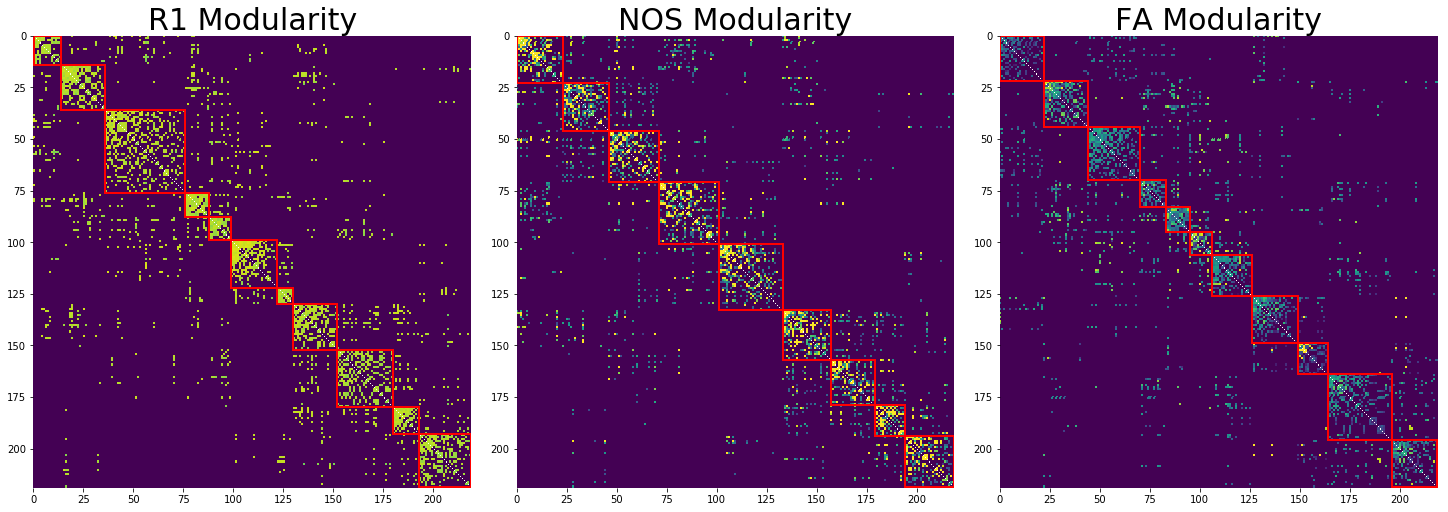

In [16]:
%matplotlib inline
figure_mod, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(20,7))
axs[0].set_title('R1 Modularity', fontsize=30)
axs[1].set_title('NOS Modularity', fontsize=30)
axs[2].set_title('FA Modularity', fontsize=30)

plotting.plot_mod_heatmap(consensusNetworks["r1"], consensus_r1, cmap='viridis', edgecolor='red', ax=axs[0], cbar=False)
plotting.plot_mod_heatmap(consensusNetworks["nos"], consensus_nos, cmap='viridis', edgecolor='red', ax=axs[1], cbar=False)
plotting.plot_mod_heatmap(consensusNetworks["fa"], consensus_fa, cmap='viridis', edgecolor='red', ax=axs[2], cbar=False)

In [17]:
from plotly.subplots import make_subplots

fig = go.Figure()
for i in R1modules_yeo.keys():
    fig.add_trace(go.Bar(name="Module " + i, text=["M"+i if u>0 else "" for u in list(R1modules_yeo_ocurances[i].values())/yeo_classes_count], x=list(R1modules_yeo_ocurances[i].keys()), y=list(R1modules_yeo_ocurances[i].values())/yeo_classes_count))

# Change the bar mode
for i in range(0,7):
    fig.add_shape(
            # Line Diagonal
                type="line",
                x0=0.5+i,
                y0=0,
                x1=0.5+i,
                y1=0.7,
                line=dict(
                    color="MediumPurple",
                    width=4,
                    dash="dot",
                )
    )
fig.update_shapes(dict(xref='x', yref='y'))
fig.update_layout(barmode='group', title = "Distribution of functional Yeo's classes per R1 module", colorway=px.colors.qualitative.Set3, width=3000, xaxis_tickfont_size=20, yaxis_tickfont_size=20,legend=dict(font=dict(size=20)),uniformtext_minsize=20, uniformtext_mode='show')
fig.update_yaxes(range=[0, 0.7])
iplot(fig)

fig1 = go.Figure()
for i in NOSmodules_yeo.keys():
    fig1.add_trace(go.Bar(name="Module " + i, text=["M"+i if u>0 else "" for u in list(NOSmodules_yeo_ocurances[i].values())/yeo_classes_count], x=list(NOSmodules_yeo_ocurances[i].keys()), y=list(NOSmodules_yeo_ocurances[i].values())/yeo_classes_count))

# Change the bar mode
for i in range(0,7):
    fig1.add_shape(
            # Line Diagonal
                type="line",
                x0=0.5+i,
                y0=0,
                x1=0.5+i,
                y1=0.7,
                line=dict(
                    color="MediumPurple",
                    width=4,
                    dash="dot",
                )
    )
fig1.update_shapes(dict(xref='x', yref='y'))
fig1.update_layout(barmode='group', title = "Distribution of functional Yeo's classes per NOS module", colorway=px.colors.qualitative.Set3, width=3000, xaxis_tickfont_size=20, yaxis_tickfont_size=20,legend=dict(font=dict(size=20)),uniformtext_minsize=20, uniformtext_mode='show')
fig1.update_yaxes(range=[0, 0.7])
iplot(fig1)



fig2 = go.Figure()
for i in FAmodules_yeo.keys():
    fig2.add_trace(go.Bar(name="Module " + i, text=["M"+i if u>0 else "" for u in list(FAmodules_yeo_ocurances[i].values())/yeo_classes_count], x=list(FAmodules_yeo_ocurances[i].keys()), y=list(FAmodules_yeo_ocurances[i].values())/yeo_classes_count))

# Change the bar mode
for i in range(0,7):
    fig2.add_shape(
            # Line Diagonal
                type="line",
                x0=0.5+i,
                y0=0,
                x1=0.5+i,
                y1=0.7,
                line=dict(
                    color="MediumPurple",
                    width=4,
                    dash="dot",
                )
    )
fig2.update_shapes(dict(xref='x', yref='y'))
fig2.update_layout(barmode='group', title = "Distribution of functional Yeo's classes per FA module", colorway=px.colors.qualitative.Set3, width=3000, xaxis_tickfont_size=20, yaxis_tickfont_size=20,legend=dict(font=dict(size=20)),uniformtext_minsize=20, uniformtext_mode='show')
fig2.update_yaxes(range=[0, 0.7])
iplot(fig2)